# Student performance
Natalia Vélez, February 2022

In [29]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# sys.path.append('..')
from utils import gsearch, read_json, int_extract

# sys.path.append('../2_behavioral')
# import teaching_models as teach

sns.set_context('talk')
sns.set_style('white')

Load student data:

In [30]:
student_df = pd.read_csv('student_behavior.csv')
# student_df['num_hint'] = (student_df['num_hint'] + 1).astype(int)
# student_df['problem'] = student_df['problem'].astype(int)
student_df['num_hint'] = student_df['num_hint'] + 1
student_df['teacher'] = student_df.teacher.apply(lambda s: int_extract('(?<=sub-)[0-9]+', s))
student_df['bets'] = student_df.bets.apply(literal_eval)
#student_df = student_df.rename(columns={'order': 'trial_order'})

print('Loaded data from %i/140 students' % student_df.worker.nunique())
student_df.head()

Loaded data from 140/140 students


,time_elapsed,teacher,problem,num_trial,num_hint,bets,bonus,worker,trial_order,order,bets_sorted,belief_in_true
0,181304,4,34,0,1,"[0, 35, 41, 48]",0.013777,133,0,"['B', 'D', 'A', 'C']","[41, 0, 48, 35]",0.330645
1,192911,4,34,0,2,"[0, 50, 49, 0]",0.020623,133,0,"['B', 'D', 'A', 'C']","[49, 0, 0, 50]",0.494949
2,203582,4,34,0,3,"[0, 0, 100, 0]",0.041667,133,0,"['B', 'D', 'A', 'C']","[100, 0, 0, 0]",1.000000
3,223655,27,15,1,1,"[0, 52, 50, 48]",0.014444,133,0,"['B', 'A', 'D', 'C']","[52, 0, 48, 50]",0.346667
4,232054,27,15,1,2,"[0, 52, 50, 0]",0.021242,133,0,"['B', 'A', 'D', 'C']","[52, 0, 0, 50]",0.509804


## Performance

Change in bonus over time

[Text(0.5, 0, '# Hints presented'), Text(0, 0.5, 'Score')]

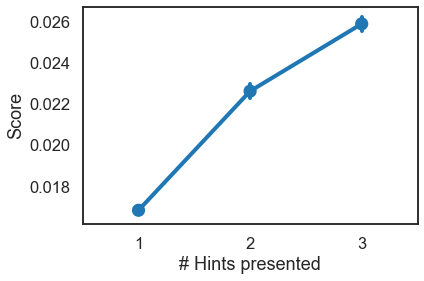

In [31]:
ax=sns.pointplot(data=student_df, x='num_hint', y ='bonus')
ax.set(xlabel='# Hints presented', ylabel='Score')
# ax.axhline(5.0/40/3, linestyle='--', color='#aaa')
# sns.despine()

Average bonus by problem

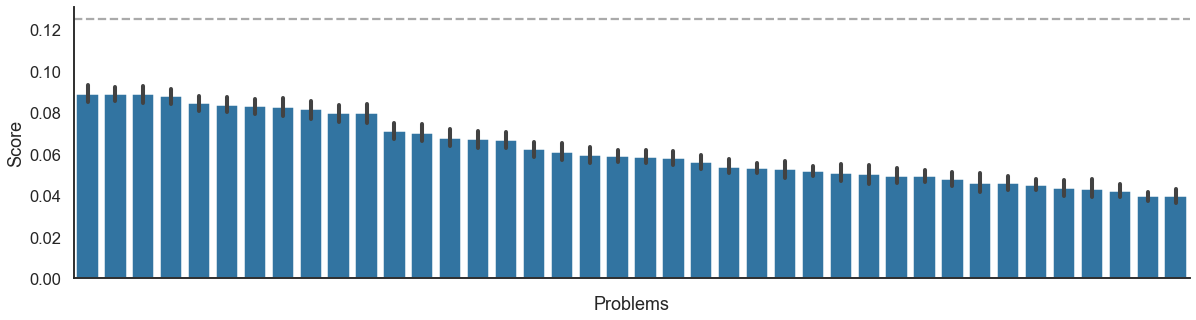

In [32]:
problem_avg = student_df.groupby(['worker', 'problem']).agg({'bonus': 'sum'}).reset_index()
problem_avg['hue_group'] = 1
problem_difficulty = (
    problem_avg
    .groupby('problem')
    .agg({'bonus': 'mean'})
    .reset_index()
    .sort_values(by='bonus', ascending=False)
)

fig,ax=plt.subplots(figsize=(20,5))
sns.barplot(data=problem_avg, x='problem', y='bonus', hue='hue_group', order=problem_difficulty.problem.values, ax=ax)
ax.legend().remove()
ax.set(xlabel='Problems', ylabel='Score', xticklabels=[])
ax.axhline(y=5.0/40, linestyle='--', color = '#aaa')
sns.despine()

Average bonus by teacher

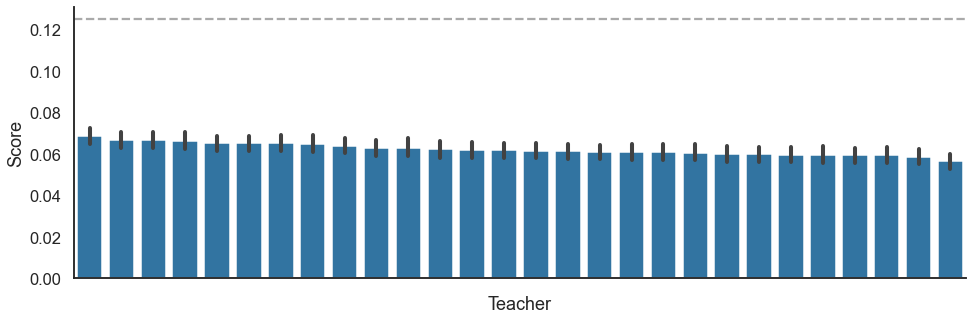

In [33]:
teacher_avg = student_df.groupby(['worker', 'problem', 'teacher']).agg({'bonus': 'sum'}).reset_index()
teacher_avg['hue_group'] = 1
teacher_quality = (
    teacher_avg
    .groupby('teacher')
    .agg({'bonus': 'mean'})
    .reset_index()
    .sort_values(by='bonus', ascending=False)
)

fig,ax=plt.subplots(figsize=(16,5))
sns.barplot(data=teacher_avg, x='teacher', y='bonus', hue='hue_group', ax=ax, order=teacher_quality.teacher.values)
ax.legend().remove()
ax.set(xlabel='Teacher', ylabel='Score', xticklabels=[])
ax.axhline(y=5.0/40, linestyle='--', color = '#aaa')
sns.despine()

## Correlation with teacher ratings

Load teacher data:

In [34]:
teach_df = (
    pd.read_csv('teaching_behavior.csv')
    .rename(columns={'subject': 'teacher', 'rating': 'teacher_rating'})
)

# align teacher trial indices with students'
teach_df['hint_presented'] = ~pd.isna(teach_df['example'])*1
teach_df['num_hint'] = teach_df.groupby(['teacher', 'problem']).hint_presented.transform('cumsum')
teach_df['num_hint'] = np.where(teach_df.hint_presented, teach_df.num_hint, np.nan)
teach_df = teach_df.drop(columns=['ex_idx', 'hint_presented'])

teach_df.head(15)

,teacher,run,block_idx,first_movement,start,onset,problem,order,example,teacher_rating,num_hint
0,1,1,0,"[0, 1]","[0, 0]",30.00,22,"['C', 'B', 'D', 'A']","[1, 2]",1.0,1.0
1,1,1,0,"[0, 1]","[0, 0]",45.35,22,"['C', 'B', 'D', 'A']","[4, 3]",2.0,2.0
2,1,1,0,"[0, 1]","[0, 0]",59.35,22,"['C', 'B', 'D', 'A']",NaN,2.0,NaN
3,1,1,1,"[0, 4]","[0, 5]",104.05,18,"['D', 'B', 'C', 'A']","[0, 3]",0.0,1.0
4,1,1,1,"[0, 4]","[0, 5]",118.45,18,"['D', 'B', 'C', 'A']","[5, 2]",NaN,2.0
5,1,1,1,"[0, 4]","[0, 5]",132.55,18,"['D', 'B', 'C', 'A']","[1, 1]",3.0,3.0
6,1,1,2,"[5, 4]","[5, 5]",175.90,1,"['A', 'D', 'C', 'B']","[5, 1]",1.0,1.0
7,1,1,2,"[5, 4]","[5, 5]",192.70,1,"['A', 'D', 'C', 'B']","[0, 1]",4.0,2.0
8,1,1,2,"[5, 4]","[5, 5]",207.30,1,"['A', 'D', 'C', 'B']","[0, 4]",4.0,3.0
9,1,1,3,"[5, 1]","[5, 0]",254.65,16,"['B', 'C', 'A', 'D']",NaN,0.0,NaN


Load problem orders:

In [35]:
problem_orders = (
    teach_df
    [['teacher', 'problem', 'order']]
    .drop_duplicates()
)
problem_orders['order'] = problem_orders.order.apply(literal_eval)
problem_orders.head()

,teacher,problem,order
0,1,22,"[C, B, D, A]"
3,1,18,"[D, B, C, A]"
6,1,1,"[A, D, C, B]"
9,1,16,"[B, C, A, D]"
12,1,20,"[D, C, A, B]"


Reorder student bets to align with model-predicted belief distribution:

In [55]:
def sort_bets(row):
    beliefs_sorted = [bet for h, bet in sorted(zip(row.order, row.bets))]
    return beliefs_sorted

student_belief = student_df.copy().merge(problem_orders, on =['teacher', 'problem'], how='left')
student_belief['bets_sorted'] = student_belief.apply(sort_bets, axis=1)
student_belief['belief_in_true'] = student_belief.bets_sorted.apply(lambda b: b[0]/sum(b))
student_belief.head(20)


AttributeError: 'Series' object has no attribute 'order'

In [56]:
print(student_belief)
problem_list = [2, 4, 7, 8, 9, 13, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 31, 32, 33, 36, 39]

# only keep hte rows where problem is in problem_list
student_belief = student_belief[student_belief['problem'].isin(problem_list)]


       time_elapsed  teacher  problem  num_trial  num_hint             bets  \
0            181304        4       34          0         1  [0, 35, 41, 48]   
1            192911        4       34          0         2   [0, 50, 49, 0]   
2            203582        4       34          0         3   [0, 0, 100, 0]   
3            223655       27       15          1         1  [0, 52, 50, 48]   
4            232054       27       15          1         2   [0, 52, 50, 0]   
...             ...      ...      ...        ...       ...              ...   
16145       3493912       27        0         38         2   [0, 100, 0, 0]   
16146       3496984       27        0         38         3   [0, 100, 0, 0]   
16147       3565110        1       14         39         1   [58, 0, 63, 0]   
16148       3568346        1       14         39         2   [80, 0, 63, 0]   
16149       3572248        1       14         39         3  [100, 0, 24, 0]   

          bonus  worker  trial_order               

Belief in true hypothesis over time:

[Text(0.5, 0, '# Examples'), Text(0, 0.5, 'Bets on correct answer')]

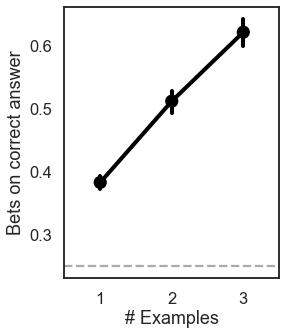

In [57]:
avg_student_belief = student_belief.groupby(['worker', 'num_hint']).agg({'belief_in_true': 'mean'}).reset_index()
fig,ax=plt.subplots(figsize=(5/1.3,5))
sns.pointplot(data=avg_student_belief,x='num_hint',y='belief_in_true', color='k', linewidth=4, ax=ax)
ax.axhline(y=0.25, linestyle='--', color='#aaa')
ax.set(xlabel='# Examples', ylabel='Bets on correct answer')

# plt.savefig('plots/student_belief.pdf', bbox_inches='tight')

Load teacher ratings:

In [58]:
teacher_ratings = (
    teach_df
    .copy()
    [['teacher', 'problem', 'num_hint', 'teacher_rating']]
    .dropna(subset=['num_hint', 'teacher_rating'])
)
teacher_ratings['teacher_rating'] = (teacher_ratings['teacher_rating']+1).astype(int)# rescale to 1-5

print(teacher_ratings.shape)
teacher_ratings.head()

(3319, 4)


,teacher,problem,num_hint,teacher_rating
0,1,22,1.0,2
1,1,22,2.0,3
3,1,18,1.0,1
5,1,18,3.0,4
6,1,1,1.0,2


Students' bets vs. teachers' ratings:

[Text(0.5, 0, 'Teachers:\n"How likely are students\nto get it right?"'),
 Text(0, 0.5, 'Learners:\nBets on correct answer')]

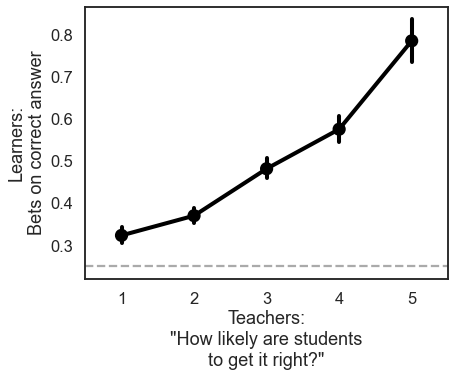

In [59]:
fig,ax=plt.subplots(figsize=(5*1.3, 5))
students_vs_teachers = student_belief.merge(teacher_ratings)
students_vs_teachers = students_vs_teachers.groupby(['teacher', 'teacher_rating']).agg({'belief_in_true': 'mean'}).reset_index()

sns.pointplot(data=students_vs_teachers, x='teacher_rating', y='belief_in_true', color='k', lw=4, ax=ax)
ax.axhline(y=0.25, linestyle='--', color='#aaa')
ax.set(xlabel='Teachers:\n"How likely are students\nto get it right?"',
       ylabel='Learners:\nBets on correct answer')

# plt.savefig('plots/students_vs_teachers.pdf', bbox_inches='tight')

## Variability in teacher quality

Prepare regression inputs:

`belief_in_true ~ num_hint * rating + (1|problem) + (1|student) + (rating|teacher)`

In [60]:
student_performance = student_belief.merge(teacher_ratings)
student_performance.head()

,time_elapsed,teacher,problem,num_trial,num_hint,bets,bonus,worker,trial_order,order_x,bets_sorted,belief_in_true,order_y,teacher_rating
0,181304,4,34,0,1,"[0, 35, 41, 48]",0.013777,133,0,"['B', 'D', 'A', 'C']","[41, 0, 48, 35]",0.330645,"[B, D, A, C]",2
1,1103234,4,34,33,1,"[0, 43, 41, 48]",0.012942,137,47,"['B', 'D', 'A', 'C']","[41, 0, 48, 43]",0.310606,"[B, D, A, C]",2
2,1035089,4,34,6,1,"[0, 54, 44, 42]",0.013095,38,78,"['B', 'D', 'A', 'C']","[44, 0, 42, 54]",0.314286,"[B, D, A, C]",2
3,429957,4,34,10,1,"[0, 25, 25, 25]",0.013889,6,102,"['B', 'D', 'A', 'C']","[25, 0, 25, 25]",0.333333,"[B, D, A, C]",2
4,1011954,4,34,34,1,"[0, 2, 99, 4]",0.039286,67,113,"['B', 'D', 'A', 'C']","[99, 0, 4, 2]",0.942857,"[B, D, A, C]",2


Save to file:

In [62]:
student_performance.to_csv('outputs/student_beliefs.csv', index=False)